# 3. Managing Experiments and Hyperparameter Tuning

Now that we're a lot more familiar with the lightning API we can focus on a couple more practical aspects. In this tutorial we'll learn how to:

1. Use Weights&Biases to track experiments
2. See some more ways to measure the performance of a model
3. Learn how to perform hyperparameter tuning

In [62]:
!pip install lightning

In [63]:
import wandb
import os
from io import BytesIO
from PIL import Image
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
import lightning as L
from torch.utils.data import DataLoader, TensorDataset
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, Callback
from lightning.pytorch.loggers import WandbLogger
import torchmetrics.classification as metrics

from typing import List

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, confusion_matrix

This time we'll work on a different dataset, the [wine quality](https://archive.ics.uci.edu/dataset/186/wine+quality) dataset. This is a **multi-class classification** problem, so some things will differ (the shape of the data/preds, the loss and metrics, etc.) from how we approached the previous binary classification problems.

In [64]:
data = pd.read_csv('https://raw.githubusercontent.com/djib2011/pytorch-training/refs/heads/master/data/winequality-white.csv', sep=';')

data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


This dataset has 11 continuous features and the label, which has int values from 3 to 9.

Let's prepare the data.

In [66]:
X = data.drop(columns='quality')
y = data['quality'] - data['quality'].min()  # make labels start from 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f'{X_train.shape = }, {X_test.shape = }, {y_train.shape = }, {y_test.shape = }\n')
print(y.value_counts())

X_train.shape = (3673, 11), X_test.shape = (1225, 11), y_train.shape = (3673,), y_test.shape = (1225,)

quality
3    2198
2    1457
4     880
5     175
1     163
0      20
6       5
Name: count, dtype: int64


Create the data loaders...

In [ ]:
# Create the training set data loader
x_tensor = torch.from_numpy(X_train).float()
y_tensor = torch.from_numpy(y_train.values)
dataset = TensorDataset(x_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

# Create the validation set data loader
x_val_tensor = torch.from_numpy(X_test).float()
y_val_tensor = torch.from_numpy(y_test.values)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)

And finally create our classifier. Here we'll change a lot of things

In [ ]:
class WineQualityClassifier(L.LightningModule):
    INPUT_DIM = 11
    NUM_CLASSES = OUTPUT_DIM = 7

    def __init__(self, hidden_layer_sizes: List[int], hidden_layer_activation: str,
                 optimizer: str, learning_rate: float, weight_decay: float,
                 dropout_prob: float, early_stopping: bool, lr_scheduler: str):
        super().__init__()

        # Define NN layers
        prev = self.INPUT_DIM
        self.hidden = []
        for size in hidden_layer_sizes:
            self.hidden.append(nn.Linear(prev, size))
            prev = size
        self.output = nn.Linear(prev, self.OUTPUT_DIM)

        # Define activations
        self.activation = getattr(nn, hidden_layer_activation, None)()
        self.softmax = nn.Softmax(dim=1)

        # Define dropout
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(dropout_prob)

        # Store optimizer's params and lr scheduler
        self.optimizer_name = optimizer
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.lr_scheduler = lr_scheduler

        # Store early stopping flag
        self.early_stopping = early_stopping

        # Define loss and metrics
        self.loss_func = nn.CrossEntropyLoss()
        self.accuracy = metrics.Accuracy(task='multiclass', num_classes=self.NUM_CLASSES)
        self.precision = metrics.Precision(task='multiclass', num_classes=self.NUM_CLASSES)
        self.recall = metrics.Recall(task='multiclass', num_classes=self.NUM_CLASSES)
        self.f1_score = metrics.F1Score(task='multiclass', num_classes=self.NUM_CLASSES)
        self.auroc = metrics.AUROC(task='multiclass', num_classes=self.NUM_CLASSES)

        # Activate save_hyperparameters flag
        self.save_hyperparameters()

    def forward(self, x):

        for layer in self.hidden:
            x = layer(x)
            x = self.activation(x)
            x = self.dropout(x)

        x = self.softmax(self.output(x))

        return x

    def training_step(self, batch, batch_idx):

        # Forward propagation
        x, y = batch
        preds = self(x)

        # Compute and log metrics
        metrics = {f'train_{name}': value for name, value in self.compute_metrics(preds, y).items()}
        self.log_dict(metrics, on_step=True,on_epoch=True, prog_bar=True)

        metrics['loss'] = metrics['train_loss']
        return metrics


    def validation_step(self, batch, batch_idx):

        # Forward propagation
        x, y = batch
        preds = self(x)

        # Compute and log metrics
        metrics = {f'val_{name}': value for name, value in self.compute_metrics(preds, y).items()}
        self.log_dict(metrics, on_epoch=True, prog_bar=True)

        metrics['preds'] = preds  # Also return preds, this will make our life easier later on
        return metrics

    def configure_optimizers(self):
        optimizer_class = getattr(optim, self.optimizer_name, None)
        optimizer = optimizer_class(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

        lr_scheduler_config = self._congigure_scheduler(optimizer)

        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler_config}

    def configure_callbacks(self):

        # Define the ModelCheckpoint callback
        model_checkpoint = ModelCheckpoint(dirpath='checkpoints',
                                           filename='{epoch}-{val_f1_score:.2f}',
                                           monitor='val_f1_score',
                                           mode='max',
                                           save_top_k=1)

        # If 'early_stopping' flag is set, also add this callback
        if self.early_stopping:
            early_stopping = EarlyStopping(monitor='val_loss', mode='min')
            return [model_checkpoint, early_stopping]

        return model_checkpoint

    def _congigure_scheduler(self, optimizer):
        """
        Define a lr_scheduler_config based on the 'lr_scheduler' string provided
        during the class init.

        For most of the schedulers we'll use the default parameters.
        """

        if self.lr_scheduler == 'step':
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

        elif self.lr_scheduler == 'exponential':
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

        elif self.lr_scheduler == 'cyclical':
            scheduler = optim.lr_scheduler.CyclicLR(optimizer,
                                                    base_lr=self.learning_rate / 2,
                                                    max_lr=self.learning_rate * 5)

        elif self.lr_scheduler == 'reduce_on_plateau':
              scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

        else:
            # Use constant LR if no schedule is provided
            scheduler = optim.lr_scheduler.ConstantLR(optimizer, factor=1)


        lr_scheduler_config = {'scheduler': scheduler, 'interval': 'epoch', 'frequency': 1}

        return lr_scheduler_config

    def compute_metrics(self, preds, targets):
        """
        Compute loss and all metrics on a set of predictions
        """

        preds_labels = torch.argmax(preds, dim=1)

        metrics = {
            'loss': self.loss_func(preds, targets),
            'accuracy': self.accuracy(preds_labels, targets),
            'precision': self.precision(preds_labels, targets),
            'recall': self.recall(preds_labels, targets),
            'f1_score': self.f1_score(preds_labels, targets),
            'AUROC': self.auroc(preds, targets),
        }
        return metrics

In [ ]:
hparams = dict(hidden_layer_sizes=[100],        # 1 hidden layer with 100 neurons
               hidden_layer_activation='ReLU',  # ReLU activation for hidden layer
               optimizer='Adam',                # Adam optimizer
               learning_rate=0.01,              # LR=0.01 for Adam
               weight_decay=0,                  # No weight decay
               dropout_prob=0,                  # No dropout
               early_stopping=False,            # No early stopping
               lr_scheduler=None)               # No LR scheduler

model = WineQualityClassifier(**hparams)

In [ ]:
trainer = L.Trainer(max_epochs=5)

trainer.fit(model=model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

print(f'Validation F1: {trainer.logged_metrics["val_f1_score"]*100:.2f}%')

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Validation F1: 52.73%


In [ ]:
with open('wandb-api-key.txt') as f:
    os.environ['WANDB_API_KEY'] = f.read().replace('\n', '')

In [ ]:
wandb.login()

True

In [ ]:
model = WineQualityClassifier(**hparams)

In [ ]:
wandb.init(project='pytorch-training-test')

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


In [ ]:
wandb_logger = WandbLogger(project='pytorch-training-test', log_model='all')

trainer = L.Trainer(max_epochs=10, logger=wandb_logger)

trainer.fit(model=model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

print(f'Validation F1: {trainer.logged_metrics["val_f1_score"]*100:.2f}%')

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO: 
  | Name       | Type 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Validation F1: 54.29%


In [ ]:
wandb.finish()

epoch,▁▁▂▂▃▃▃▃▃▄▄▅▅▆▆▆▆▆▇▇███
train_AUROC_epoch,▁▄▆▆▇█▇█▇▇
train_AUROC_step,▁█▇
train_accuracy_epoch,▁▅▆▇▇█████
train_accuracy_step,█▆▁
train_f1_score_epoch,▁▅▆▇▇█████
train_f1_score_step,█▆▁
train_loss_epoch,█▃▃▂▂▁▁▁▁▁
train_loss_step,▅▁█
train_precision_epoch,▁▅▆▇▇█████
train_precision_step,█▆▁


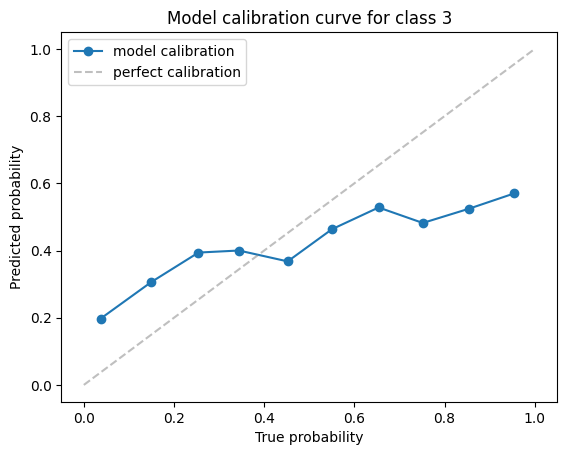

In [ ]:
with torch.inference_mode():
    y_pred = model(x_val_tensor)

y_true_onehot = F.one_hot(y_val_tensor, num_classes=model.NUM_CLASSES)

class_idx = 3
y_class_pred = y_pred[:, class_idx].numpy()
y_class_true = y_true_onehot[:, class_idx].numpy()

prob_true, prob_pred = calibration_curve(y_class_true, y_class_pred, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='model calibration')
plt.plot([0, 1], [0, 1], color='gray', ls='--', alpha=0.5, label='perfect calibration')
plt.title(f'Model calibration curve for class {class_idx}')
plt.xlabel('True probability')
plt.ylabel('Predicted probability')
plt.legend();

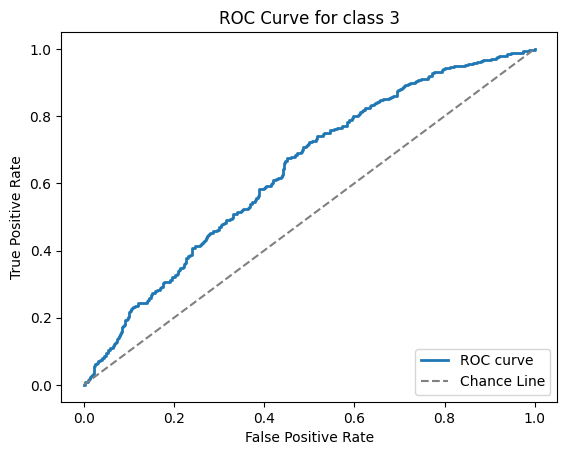

In [ ]:
fpr, tpr, _ = roc_curve(y_class_true, y_class_pred)

# Plot ROC curve
plt.plot(fpr, tpr, lw=2, label=f'ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance Line')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for class {class_idx}')
plt.legend(loc='lower right')

In [ ]:
all_preds, all_labels = [], []

for batch in val_loader:
    x, y = batch
    outputs = model(x)
    preds = torch.argmax(outputs, dim=1)

    all_preds.extend(preds.numpy())
    all_labels.extend(y.numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Convert confusion matrix to WandB Table format
columns = [f'Pred_{i}' for i in range(conf_matrix.shape[1])]
index = [f'Label_{i}' for i in range(conf_matrix.shape[1])]

pd.DataFrame(conf_matrix, columns=columns, index=index)

,Pred_0,Pred_1,Pred_2,Pred_3,Pred_4,Pred_5,Pred_6
Label_0,0,0,1,5,0,0,0
Label_1,0,0,22,14,1,0,0
Label_2,0,0,206,158,3,0,0
Label_3,0,0,105,408,30,0,0
Label_4,0,0,16,164,51,0,0
Label_5,0,0,0,25,15,0,0
Label_6,0,0,0,0,1,0,0


In [ ]:
class WandbLoggingCallback(Callback):
    def __init__(self, log_frequency_epochs: int = 1):
        self.freq = log_frequency_epochs
        self.all_preds = []
        self.all_labels = []

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
        # Append predictions and labels at the end of each validation batch
        x, y = batch

        self.all_preds.extend(outputs['preds'])
        self.all_labels.extend(y)

    def on_validation_epoch_end(self, trainer, pl_module):

        # Log only every `log_frequency_epochs` (as defined in init) epochs and on the last epoch
        if (trainer.current_epoch + 1) % self.freq != 0 and trainer.current_epoch + 1 != trainer.max_epochs:
            return

        # Generate calibration and roc curves as numpy arrays
        y_true_tensor = torch.stack(self.all_labels)
        y_pred_tensor = torch.stack(self.all_preds)
        y_pred_tensor_label = torch.argmax(y_pred_tensor, dim=1)
        calibration_images = pl_module.plot_calibration_curves(y_true_tensor, y_pred_tensor)
        roc_images = pl_module.plot_roc_curves(y_true_tensor, y_pred_tensor)
        cm_table_data, cm_columns = pl_module.compute_confusion_matrix(y_true_tensor, y_pred_tensor_label)

        # Log calibration curves to WandB
        trainer.logger.log_image(
                key=f'calibration_curves',
                images=calibration_images,
                caption=[f'Calibration curve for class {i}, epoch {trainer.current_epoch}' for i in range(len(calibration_images))])

        # Log roc curves to WandB
        trainer.logger.log_image(
                key=f'roc_curves',
                images=roc_images,
                caption=[f'RoC curve for class {i}, epoch {trainer.current_epoch}' for i in range(len(roc_images))])

        # Log table to WandB
        wandb_logger.log_table(key=f'confusion_matrix_epoch_{trainer.current_epoch}', columns=cm_columns, data=cm_table_data)

In [ ]:
class WineQualityClassifierMetrics(WineQualityClassifier):

    def plot_calibration_curves(self, y_true, y_pred):
        """
        Generate a plot of the model's calibration curve for each output class

        Will return a list of numpy arrays representing the the plots
        """
        y_true_onehot = F.one_hot(y_true, num_classes=self.NUM_CLASSES)

        calibration_curves = []

        for class_idx in range(self.OUTPUT_DIM):

            # Select predictions and labels for this class
            y_class_probs = y_pred[:, class_idx].detach().numpy()
            y_class_true = y_true_onehot[:, class_idx].detach().numpy()

            # Use sklearn's calibration_curve function for easy binning and mean computation
            prob_true, prob_pred = calibration_curve(y_class_true, y_class_probs, n_bins=10)

            # Plot calibration curve for this class
            plt.plot(prob_pred, prob_true, label='model calibration')
            plt.plot([0, 1], [0, 1], color='C0', ls='--', alpha=0.5, label='perfect calibration')
            plt.scatter(prob_pred, prob_true, c='C0')
            plt.title(f'Model calibration curve for class {class_idx}')
            plt.xlabel('True probability')
            plt.ylabel('Predicted probability')
            plt.legend()
            # plt.clf()

            # Convert plot to bytes
            buf = BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)

            # Convert bytes to array
            image = np.array(Image.open(buf).convert('RGB'))

            # Clear figure for the next one
            plt.clf()

            calibration_curves.append(image)

        return calibration_curves

    def plot_roc_curves(self, y_true, y_pred):
        """
        Generate a plot of the model's RoC curve for each output class

        Will return a list of numpy arrays representing the the plots
        """

        roc_curves = []

        for class_idx in range(self.OUTPUT_DIM):

            # Select predictions and labels for this class
            y_class_probs = y_pred[:, class_idx].detach().numpy()
            y_class_true = y_true_onehot[:, class_idx].detach().numpy()

            # Use sklearn's roc_curve function to compute the ROC curve values
            fpr, tpr, _ = roc_curve(y_class_true, y_class_pred)

            # Plot ROC curve
            plt.plot(fpr, tpr, lw=2, label=f'ROC curve')
            plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance Line')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve for class {class_idx}')
            plt.legend(loc='lower right')

            # Convert plot to bytes
            buf = BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)

            # Convert bytes to array
            image = np.array(Image.open(buf).convert('RGB'))

            # Clear figure for the next one
            plt.clf()

            roc_curves.append(image)

        return roc_curves

    def compute_confusion_matrix(self, y_true, y_pred):

        # Compute confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred)

        # Convert confusion matrix to WandB Table format
        columns = ['Label'] + [f'Pred_{i}' for i in range(conf_matrix.shape[1])]
        table_data = [[i] + list(row) for i, row in enumerate(conf_matrix)]

        return table_data, columns

In [ ]:
wandb.init(project='pytorch-training-test')

wandb_logger = WandbLogger(project='pytorch-training-test', log_model='all')
wandb_callback = WandbLoggingCallback(log_frequency_epochs=5)  # log every 5 epochs

model = WineQualityClassifierMetrics(**hparams)

trainer = L.Trainer(max_epochs=15, logger=wandb_logger, callbacks=[wandb_callback])

trainer.fit(model=model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

wandb.finish()

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dis

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇██
train_AUROC_epoch,▁▂▄▆▆▆▅▆▆██▇▅▇█
train_AUROC_step,▁▇▂█
train_accuracy_epoch,▁▄▆▇▇▇▇▇▇▇█████
train_accuracy_step,▁█▃▃
train_f1_score_epoch,▁▄▆▇▇▇▇▇▇▇█████
train_f1_score_step,▁█▃▃
train_loss_epoch,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
train_loss_step,█▁▅▁
train_precision_epoch,▁▄▆▇▇▇▇▇▇▇█████
train_precision_step,▁█▃▃


<Figure size 640x480 with 0 Axes>

## Sweep

In [ ]:
parameters_dict = {
      'hidden_layer_sizes': {
          'values': [[50], [100], [200]]},  # 1 hidden layers of 50/100/200 neurons
      'hidden_layer_activation': {
          'values': ['ReLU', 'LeakyReLU', 'PReLU']}}  # different activation functions

In [ ]:
default_parameters = {'optimizer': {'value': 'Adam'},
                      'learning_rate': {'value': 0.01},
                      'weight_decay': {'value': 0},
                      'dropout_prob': {'value': 0},
                      'early_stopping': {'value': False},
                      'lr_scheduler': {'value': None}}

parameters_dict.update(default_parameters)

In [ ]:
sweep_config = {
  'method': 'grid',  # grid search through all possible hparam combinations
  'metric': {
      'name': 'val_loss',  # judge hyperparameters based on 'val_loss' metric
      'goal': 'minimize'   # lower values of 'val_loss' are better
  },
  'parameters': parameters_dict
}

WANDB_DISABLE_SERVICE=true

tensor(1.6211)

In [ ]:
def build_model_from_config(config):
    return WineQualityClassifierMetrics(hidden_layer_sizes=config.hidden_layer_sizes,
                                        hidden_layer_activation=config.hidden_layer_activation,
                                        optimizer=config.optimizer,
                                        learning_rate=config.learning_rate,
                                        weight_decay=config.weight_decay,
                                        dropout_prob=config.dropout_prob,
                                        early_stopping=config.early_stopping,
                                        lr_scheduler=config.lr_scheduler)


def run_experiment(config=None):

    with wandb.init() as run:

      config = wandb.config  # If called by wandb.agent, this config will be set by Sweep Controller

      model = build_model_from_config(config)

      trainer = L.Trainer(max_epochs=5)

      trainer.fit(model=model,
                  train_dataloaders=train_loader,
                  val_dataloaders=val_loader)

      run.log({'val_loss': trainer.logged_metrics['val_loss']})

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='pytorch-training-test')

Create sweep with ID: syiuadvd
Sweep URL: https://wandb.ai/canelino/pytorch-training-test/sweeps/syiuadvd


In [ ]:
wandb.agent(sweep_id, run_experiment)

wandb: Agent Starting Run: q8uujcva with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: False
wandb: 	hidden_layer_activation: ReLU
wandb: 	hidden_layer_sizes: [50]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: None
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


val_loss,▁
val_loss,1.66749


wandb: Agent Starting Run: xkz09q6n with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: False
wandb: 	hidden_layer_activation: ReLU
wandb: 	hidden_layer_sizes: [100]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: None
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | Linear              | 707    | train
1 | activation | ReLU                | 0      | train
2 | softmax    | Softmax             | 0      | train
3 | dropout    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


val_loss,▁
val_loss,1.6414


wandb: Agent Starting Run: k3f31eal with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: False
wandb: 	hidden_layer_activation: ReLU
wandb: 	hidden_layer_sizes: [200]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: None
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | Linear              | 1.4 K  | train
1 | activation | ReLU                | 0      | train
2 | softmax    | Softmax             | 0      | train
3 | dropout    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


val_loss,▁
val_loss,1.62826


wandb: Agent Starting Run: tr1jm75o with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: False
wandb: 	hidden_layer_activation: LeakyReLU
wandb: 	hidden_layer_sizes: [50]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: None
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | Linear              | 357    | train
1 | activation | LeakyReLU           | 0      | train
2 | softmax    | Softmax             | 0      | train
3 | dropout    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


val_loss,▁
val_loss,1.66203


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r0u6hms7 with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: False
wandb: 	hidden_layer_activation: LeakyReLU
wandb: 	hidden_layer_sizes: [100]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: None
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | Linear              | 707    | train
1 | activation | LeakyReLU           | 0      | train
2 | softmax    | Softmax             | 0      | train
3 | dropout    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


val_loss,▁
val_loss,1.63809


wandb: Agent Starting Run: q28m8vfe with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: False
wandb: 	hidden_layer_activation: LeakyReLU
wandb: 	hidden_layer_sizes: [200]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: None
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | Linear              | 1.4 K  | train
1 | activation | LeakyReLU           | 0      | train
2 | softmax    | Softmax             | 0      | train
3 | dropout    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


val_loss,▁
val_loss,1.62471


wandb: Agent Starting Run: bajrc8mj with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: False
wandb: 	hidden_layer_activation: PReLU
wandb: 	hidden_layer_sizes: [50]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: None
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | Linear              | 357    | train
1 | activation | PReLU               | 1      | train
2 | softmax    | Softmax             | 0      | train
3 | dropout    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


val_loss,▁
val_loss,1.65523


wandb: Agent Starting Run: e3r7bmd8 with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: False
wandb: 	hidden_layer_activation: PReLU
wandb: 	hidden_layer_sizes: [100]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: None
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | Linear              | 707    | train
1 | activation | PReLU               | 1      | train
2 | softmax    | Softmax             | 0      | train
3 | dropout    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


val_loss,▁
val_loss,1.63568


wandb: Agent Starting Run: iv3ov8iw with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: False
wandb: 	hidden_layer_activation: PReLU
wandb: 	hidden_layer_sizes: [200]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: None
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | Linear              | 1.4 K  | train
1 | activation | PReLU               | 1      | train
2 | softmax    | Softmax             | 0      | train
3 | dropout    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


val_loss,▁
val_loss,1.62415


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


[early_terminate](https://docs.wandb.ai/guides/sweeps/sweep-config-keys/#early_terminate)  
[hyperband](https://arxiv.org/abs/1603.06560)

In [ ]:
sweep_config = {
  'method': 'random',
  'metric': {
      'name': 'val_auroc',
      'goal': 'maximize'
  },
  'early_terminate':{
      'type': 'hyperband',
      'min_iter': 5
  },
  'parameters': {
      'hidden_layer_sizes': {
          'values': [[50], [100], [200],                             # 1 hidden layer
                     [50, 25], [100, 50], [200, 100],                # 2 hidden layers
                     [50, 25, 10], [100, 50, 25], [200, 100, 50]]},  # 3 hidden layers
      'hidden_layer_activation':{
          'values': ['ReLU', 'Sigmoid', 'LeakyReLU', 'PReLU']},
      'optimizer': {
          'values': ['Adam', 'AdamW', 'SGD']},
      'learning_rate': {
          'values': [0.01, 0.005, 0.001, 0.0005, 0.0001]},
      'weight_decay': {
          'values': [0, 0.0001, 0.001, 0.1]},
      'dropout_prob': {
          'values': [0, 0.25, 0.5]},
      'early_stopping': {
          'values': [True, False]},
      'lr_scheduler': {
          'values': ['None', 'step', 'exponential', 'cyclical', 'reduce_on_plateau']}
  }
}

{'train_loss_step': tensor(1.5649),
 'train_accuracy_step': tensor(0.6292),
 'train_precision_step': tensor(0.6292),
 'train_recall_step': tensor(0.6292),
 'train_f1_score_step': tensor(0.6292),
 'train_AUROC_step': tensor(0.5250),
 'val_loss': tensor(1.6211),
 'val_accuracy': tensor(0.5478),
 'val_precision': tensor(0.5478),
 'val_recall': tensor(0.5478),
 'val_f1_score': tensor(0.5478),
 'val_AUROC': tensor(0.4565),
 'train_loss_epoch': tensor(1.6106),
 'train_accuracy_epoch': tensor(0.5579),
 'train_precision_epoch': tensor(0.5579),
 'train_recall_epoch': tensor(0.5579),
 'train_f1_score_epoch': tensor(0.5579),
 'train_AUROC_epoch': tensor(0.4738)}

In [ ]:
def run_experiment(config=None):

    with wandb.init() as run:

      config = wandb.config  # If called by wandb.agent, this config will be set by Sweep Controller

      model = build_model_from_config(config)

      trainer = L.Trainer(max_epochs=5)

      trainer.fit(model=model,
                  train_dataloaders=train_loader,
                  val_dataloaders=val_loader)

      run.log(trainer.logged_metrics)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='pytorch-training-test')

Create sweep with ID: 1xxcmrjn
Sweep URL: https://wandb.ai/canelino/pytorch-training-test/sweeps/1xxcmrjn


In [ ]:
wandb.agent(sweep_id, run_experiment, count=50)

wandb: Agent Starting Run: j8meuhcn with config:
wandb: 	dropout_prob: 0.5
wandb: 	early_stopping: True
wandb: 	hidden_layer_activation: ReLU
wandb: 	hidden_layer_sizes: [200]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: exponential
wandb: 	optimizer: SGD
wandb: 	weight_decay: 0.1


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


train_AUROC_epoch,▁
train_AUROC_step,▁
train_accuracy_epoch,▁
train_accuracy_step,▁
train_f1_score_epoch,▁
train_f1_score_step,▁
train_loss_epoch,▁
train_loss_step,▁
train_precision_epoch,▁
train_precision_step,▁
train_recall_epoch,▁


wandb: Agent Starting Run: c4ptxyrb with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: False
wandb: 	hidden_layer_activation: LeakyReLU
wandb: 	hidden_layer_sizes: [200]
wandb: 	learning_rate: 0.001
wandb: 	lr_scheduler: step
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.1


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | Linear              | 1.4 K  | train
1 | activation | LeakyReLU           | 0      | train
2 | softmax    | Softmax             | 0      | train
3 | dropout    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


train_AUROC_epoch,▁
train_AUROC_step,▁
train_accuracy_epoch,▁
train_accuracy_step,▁
train_f1_score_epoch,▁
train_f1_score_step,▁
train_loss_epoch,▁
train_loss_step,▁
train_precision_epoch,▁
train_precision_step,▁
train_recall_epoch,▁


wandb: Agent Starting Run: vml5ezl1 with config:
wandb: 	dropout_prob: 0
wandb: 	early_stopping: True
wandb: 	hidden_layer_activation: PReLU
wandb: 	hidden_layer_sizes: [200, 100]
wandb: 	learning_rate: 0.01
wandb: 	lr_scheduler: cyclical
wandb: 	optimizer: AdamW
wandb: 	weight_decay: 0.001


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | output     | Linear              | 707    | train
1 | activation | PReLU               | 1      | train
2 | softmax    | Softmax             | 0      | train
3 | dropout    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]